In [30]:
#======Core============
import pandas as pd
import numpy as np
import os
import torch

#======PyForecast======
from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import *
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE

#======PyLightning======
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger

#======UEXP============
from ue.uexp.dataprocessing.processor_binance import BinanceProcessor
from ue.uexp.dataprocessing.func import *
from ue.uexp.dataprocessing.ta import *
from ue.uexp.models.util import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
DEBUG = True

In [3]:
if DEBUG:
    df = pd.read_csv('one_day_test.csv')
else:
    ### get data (set config params)
    ticker_list = ["BTCUSDT"]
    start_date = "2021-12-30"
    end_date = "2021-12-31"
    time_interval = "1s"

    p = BinanceProcessor("binance")
    df = p.download_data(ticker_list, start_date, end_date, time_interval)
    
    ## process
    df.reset_index(inplace=True)
    df.rename(columns={'index':'time'}, inplace=True)
    df['time_idx'] = df.index
    df.drop(['open','high','low','volume', 'tic'], inplace=True, axis=1)
    df['series'] = 0
    df['time'] = pd.to_datetime(df['time'])
    
df.head()

,time,close,time_idx,series
0,2021-12-30 00:00:00,46467.73,0,0
1,2021-12-30 00:00:01,46464.33,1,0
2,2021-12-30 00:00:02,46456.03,2,0
3,2021-12-30 00:00:03,46456.03,3,0
4,2021-12-30 00:00:04,46456.02,4,0


## Train/val/test split

In [7]:
#80% used for train-val, (where val is only the last future_window datapoints)
df_train_val = df[:int(0.8*len(df))]
df_test = df[int(0.8*len(df)):]

# Timeseries Dataset

In [8]:
# define dataset: lookback 30 intervals, predict 10 into future

max_encoder_length = 30
max_prediction_length = 10
prediction_length = 60
ensure_pred_len = max_prediction_length + prediction_length
training_cutoff = df_train_val["time_idx"].max() - ensure_pred_len # this allows 60 predictions (given max_prediction_length is 10)
#said smt about at least back+forward lengths
training_cutoff

138169

In [32]:
training = TimeSeriesDataSet(
    df_train_val[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="close",
    categorical_encoders={"series": NaNLabelEncoder().fit(df_train_val.series)},
    group_ids=["series"],
    # only unknown variable is "close" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["close"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    target_normalizer=TorchNormalizer()
    #allow_missing_timesteps=True,
)

In [10]:
validation = TimeSeriesDataSet.from_dataset(training, df_train_val, min_prediction_idx=training_cutoff + 1)
# ^ Generate dataset with different underlying data but same variable encoders and scalers, etc.

batch_size = 1024                     # NBEATS paper default
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [11]:
df_test.head()

,time,close,time_idx,series
138240,2021-12-31 14:24:00,10.776608,138240,0
138241,2021-12-31 14:24:01,10.776608,138241,0
138242,2021-12-31 14:24:02,10.776228,138242,0
138243,2021-12-31 14:24:03,10.776071,138243,0
138244,2021-12-31 14:24:04,10.775932,138244,0


In [12]:
# testing dataset
testing = TimeSeriesDataSet(
    df_test,
    time_idx="time_idx",
    target="close",
    categorical_encoders={"series": NaNLabelEncoder().fit(df_test.series)},
    group_ids=["series"],
    # only unknown variable is "close" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["close"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    #allow_missing_timesteps=True,            # we have full data
)

In [13]:
#testingTSDS = TimeSeriesDataSet.from_dataset(testing, df_train_val, min_prediction_idx=training_cutoff + 1)

test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
# train=False allows it to do the prediction over all values...or smt
# see here: https://github.com/jdb78/pytorch-forecasting/issues/446

## Experiment Name

In [14]:
exp_name = "{}_{}_of_{}_mel{}_mpl{}_for{}".format(
        "2021-12-30", "2021-12-31", "BTCUSD", max_encoder_length, max_prediction_length,
        prediction_length)
exp_name

'2021-12-30_2021-12-31_of_BTCUSD_mel30_mpl10_for60'

# Train Network
using `generic` parameters

In [15]:
# GENERIC Params
params_generic = {
    "stack_types": ["generic"],
    "num_blocks": [1],
    "num_block_layers": [4],
    "widths": [512],
    "sharing": [False],
    "expansion_coefficient_lengths": [32],
    # handled already in the TSDS class (i think)
    # "prediction_length": 10,
    # "context_length": 60,
    # ^ Should be between 1-10 times the prediction length (as per pyf.Nbeats docs)
    # "backcast_loss_ratio": #this the paper doesn't say...so setting as default=0 for now
    # "loss": "MASE",                                    # defaults to MASE(), paper in Generic mode used sMAPE, MAPE as well
    
    ### Base Model params
    #"logging_metrics": ['mse','mape','mae'], #for Tsb   # default looks at [SMAPE(), MAE(), RMSE(), MAPE(), MASE()]
    "optimizer": "adam",                                 # NBEATS uses adam
    "weight_decay": 0,                                   # base model default
    
}

### Pytorch Lightning Trainer

In [16]:
pl.seed_everything(42, workers=True)

Global seed set to 42


42

In [17]:
logger = TensorBoardLogger("model_data", name=exp_name, version=None)

In [18]:
trainer = pl.Trainer(logger=logger,
                     max_epochs=20,
                     default_root_dir="model_data",
                    ) #clipping gradient to prevent explosion?

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


### PYF NBEATS

In [19]:
# NBEATS paper say they use adam optimizer with default setting, initial lr as 0.001
net = NBeats.from_dataset(training, **params_generic) 


Global seed set to 42
Finding best initial lr: 100%|████████████████| 100/100 [00:25<00:00,  3.87it/s]


suggested learning rate: 0.0007943282347242816


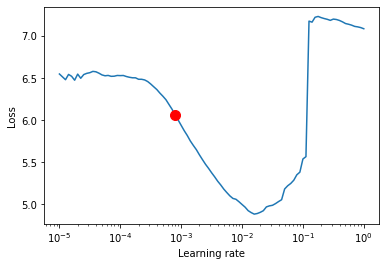

In [20]:
# find optimal learning rate
res = trainer.tuner.lr_find(net, train_dataloader=train_dataloader, val_dataloaders=val_dataloader, min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
#use suggested optimal lr
net.hparams.learning_rate = res.suggestion()

### Summary of models' params
should just be everything in params_generic with learning rate updated

In [21]:
net.hparams

"backcast_loss_ratio":           0.0
"context_length":                30
"dropout":                       0.1
"expansion_coefficient_lengths": [32]
"learning_rate":                 0.0007943282347242816
"log_gradient_flow":             False
"log_interval":                  -1
"log_val_interval":              -1
"logging_metrics":               ModuleList(
  (0): SMAPE()
  (1): MAE()
  (2): RMSE()
  (3): MAPE()
  (4): MASE()
)
"loss":                          MASE()
"monotone_constaints":           {}
"num_block_layers":              [4]
"num_blocks":                    [1]
"optimizer":                     adam
"optimizer_params":              None
"output_transformer":            EncoderNormalizer(transformation='relu')
"prediction_length":             10
"reduce_on_plateau_min_lr":      1e-05
"reduce_on_plateau_patience":    1000
"sharing":                       [False]
"stack_types":                   ['generic']
"weight_decay":                  0
"widths":                        [5

In [22]:
net.summarize()

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 837 K 
-----------------------------------------------
837 K     Trainable params
0         Non-trainable params
837 K     Total params
3.352     Total estimated model params size (MB)

In [23]:
trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 837 K 
-----------------------------------------------
837 K     Trainable params
0         Non-trainable params
837 K     Total params
3.352     Total estimated model params size (MB)


Global seed set to 42


Epoch 0:  99%|▉| 134/135 [00:34<00:00,  3.84it/s, loss=3.4, v_num=1, train_loss_
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|█| 135/135 [00:34<00:00,  3.87it/s, loss=3.4, v_num=1, train_loss_
Epoch 1:  99%|▉| 134/135 [00:35<00:00,  3.83it/s, loss=3.38, v_num=1, train_loss
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|█| 135/135 [00:35<00:00,  3.85it/s, loss=3.38, v_num=1, train_loss
Epoch 2:  99%|▉| 134/135 [00:34<00:00,  3.83it/s, loss=3.42, v_num=1, train_loss
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█| 135/135 [00:35<00:00,  3.86it/s, loss=3.42, v_num=1, train_loss
Epoch 3:  99%|▉| 134/135 [32:23<00:14, 14.50s/it, loss=3.37, v_num=1, train_loss
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█| 135/135 [32:23<00:00, 14.40s/it, loss=3.37, v_num=1, train_loss
Epoch 4:  99%|▉| 134/135 [15:08<00:06,  6.78s/it, loss=3.39, v_num=1, train_loss
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|█| 135/135 [15:08<00:00,  6.73s/it, loss=3.39, v_num=1, train_loss
Epoch 5:  99%|▉| 134/135 [00:37<00:

# Evaluate Results

In [24]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

In [25]:
# Predicting on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(8.3919e-05)

In [26]:
# look at random samples in validation set prediction
raw_predictions, x = best_model.predict(val_dataloader, mode="raw", return_x=True)

In [27]:
len(x), len(raw_predictions)

(11, 5)

In [28]:
# this encoder decoder length thing is confusing me... but yeah 41 is magic number for len(val_set)==50

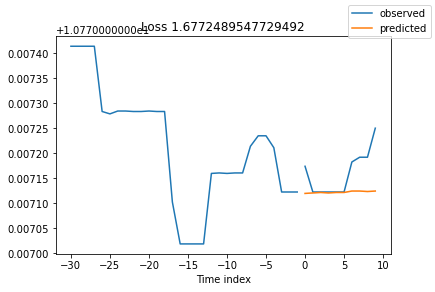

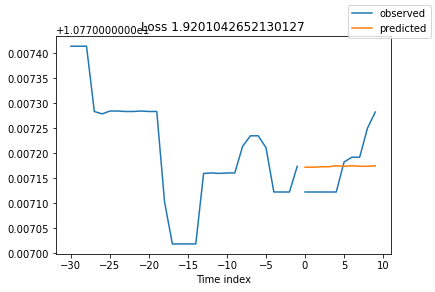

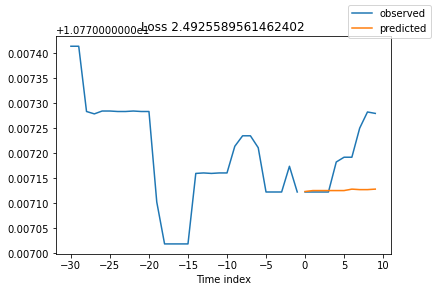

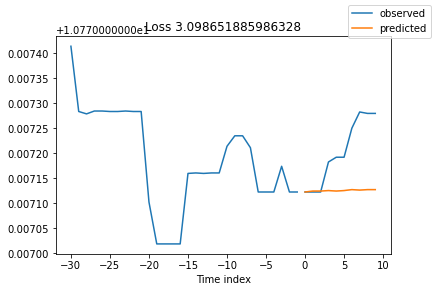

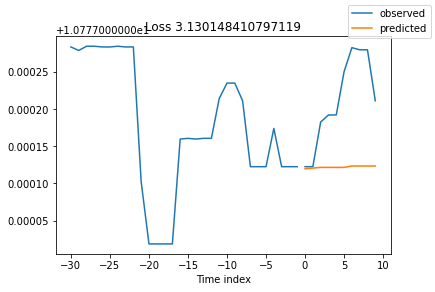

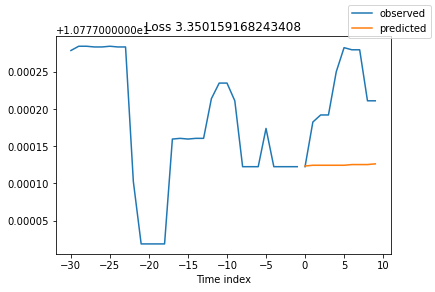

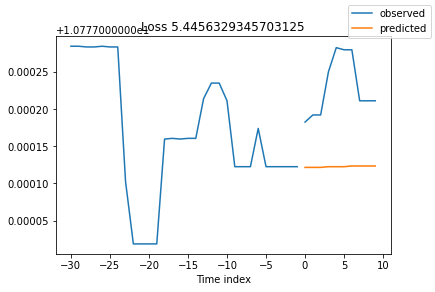

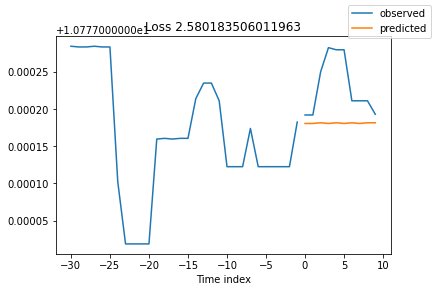

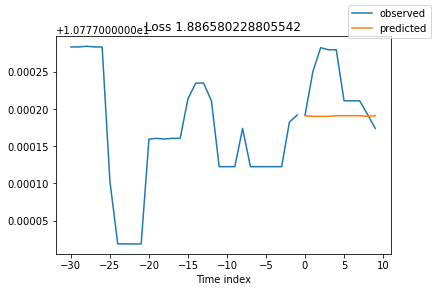

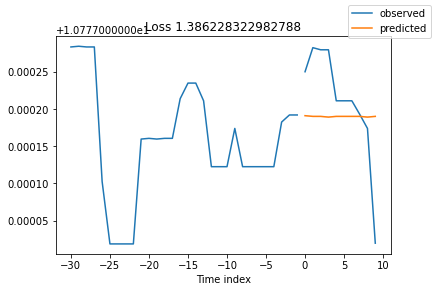

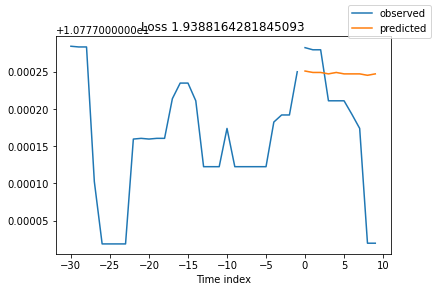

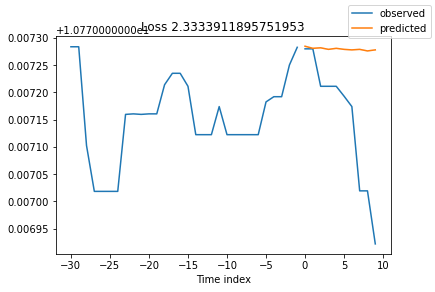

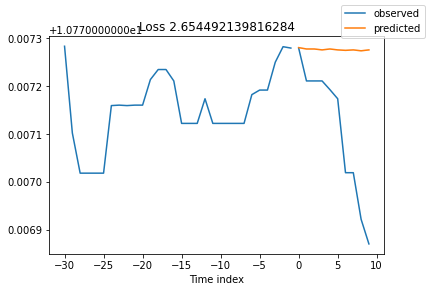

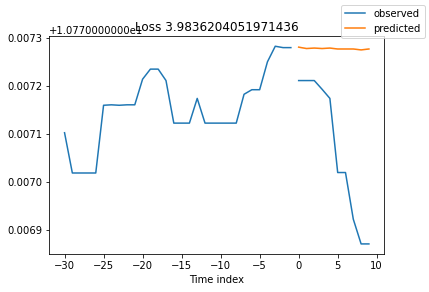

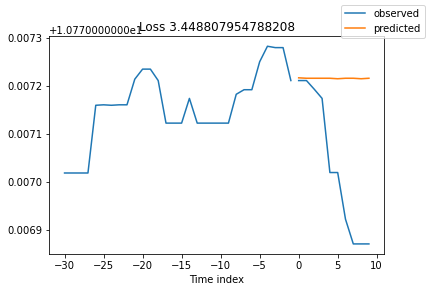

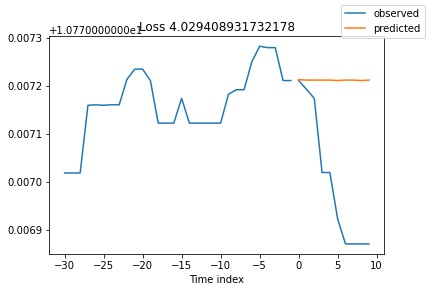

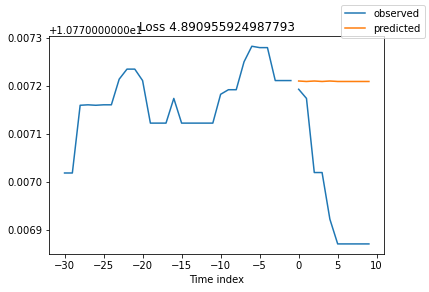

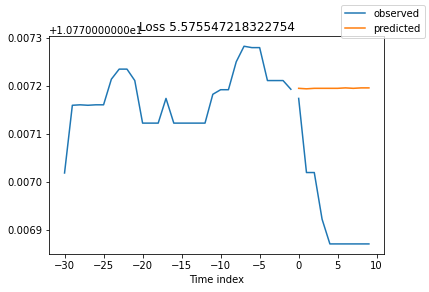

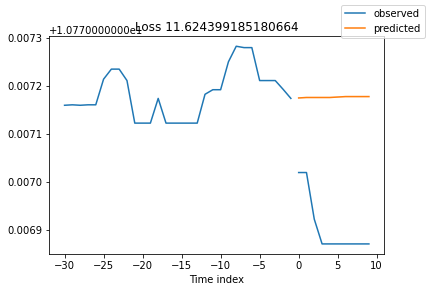

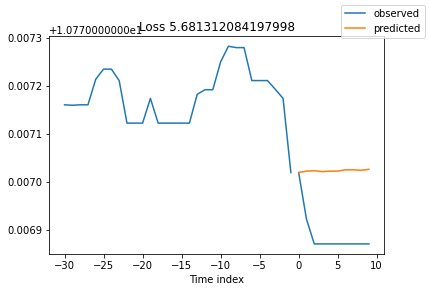

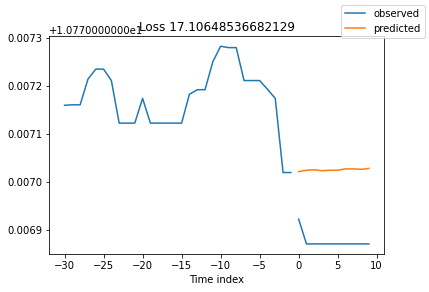

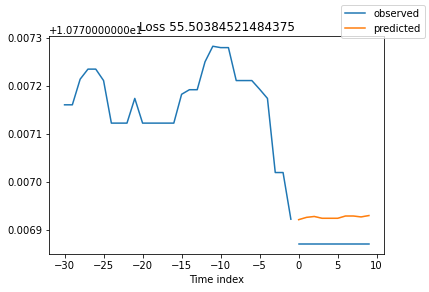

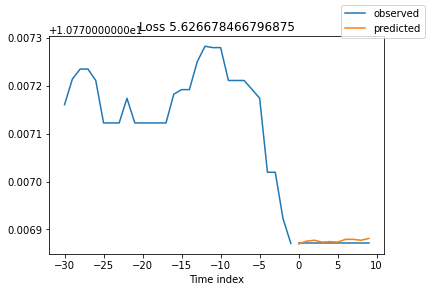

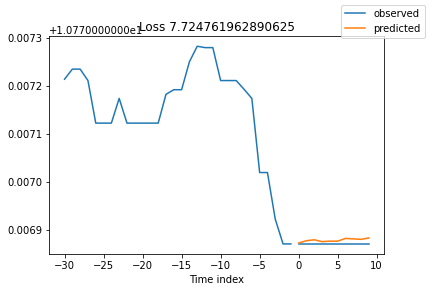

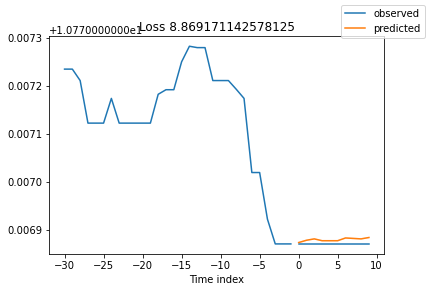

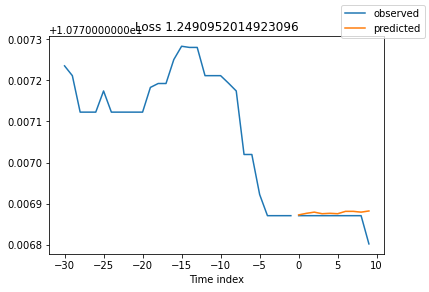

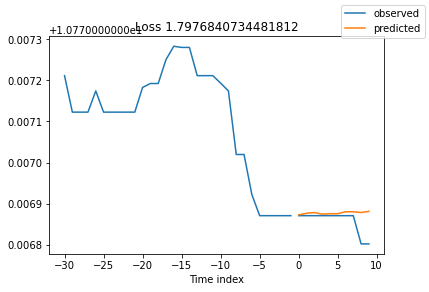

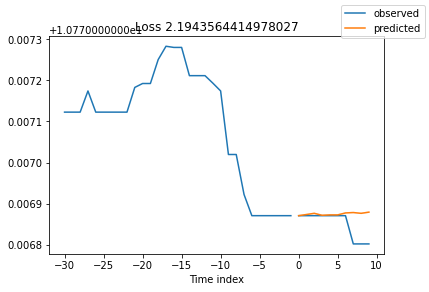

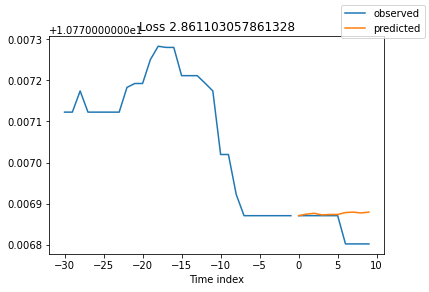

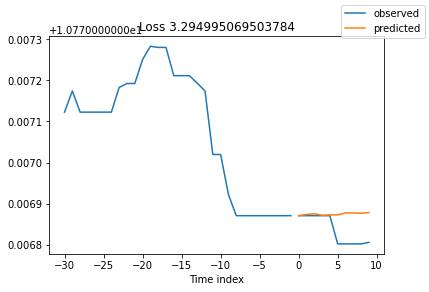

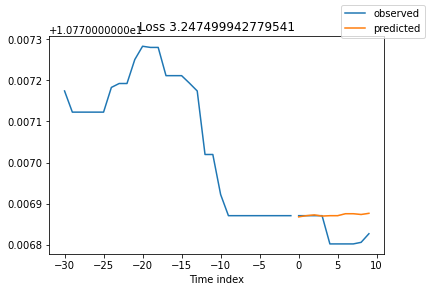

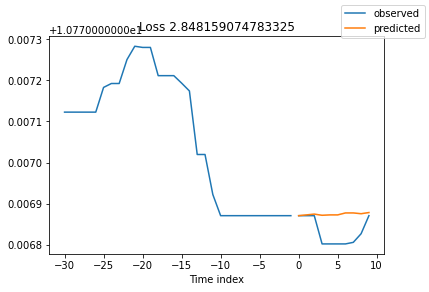

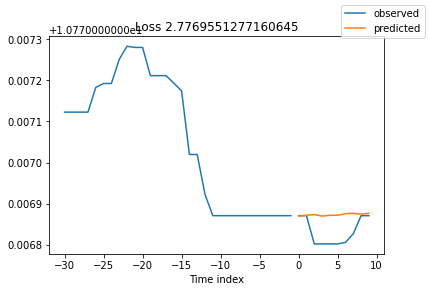

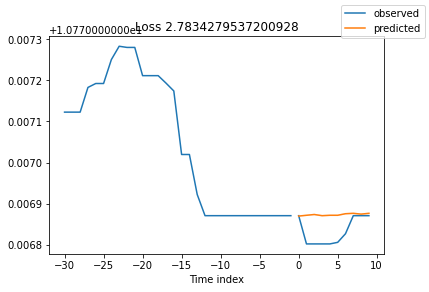

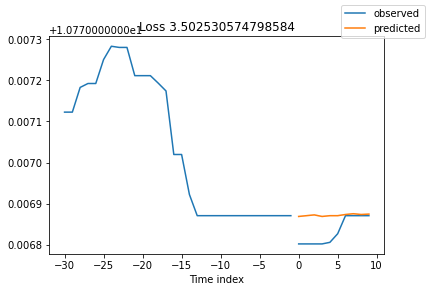

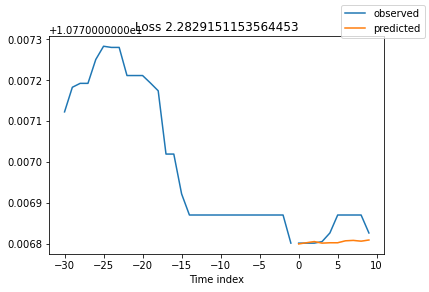

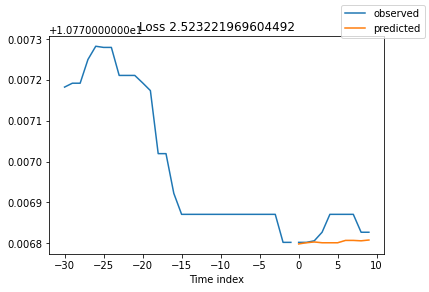

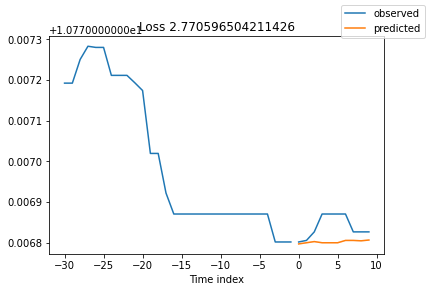

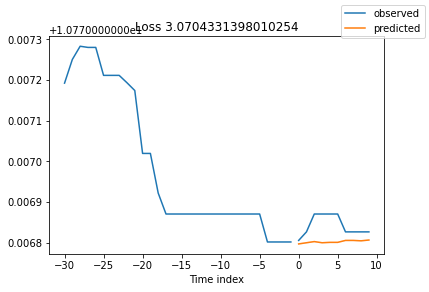

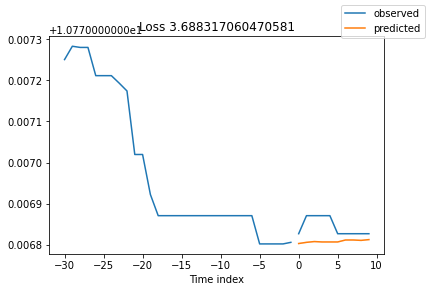

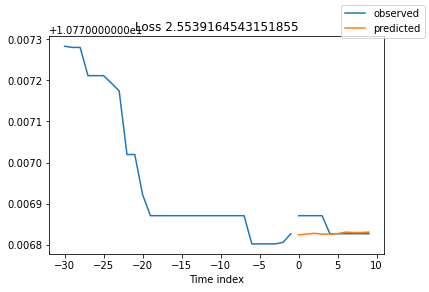

In [29]:
for idx in range(41):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

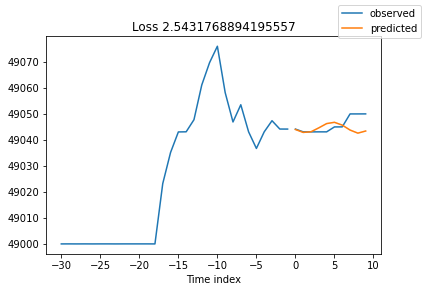

In [26]:
best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True).savefig('example_pred.png')

### Predict on testing dataset

In [27]:
os.getcwd()

'/Users/dan/Desktop/projects/uexp/ue/experiments/dan'

In [29]:
os.mkdir("experiment_plots")